In [4]:
import h5py
import numpy as np
from pathlib import Path

from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

from disp_xr import product, stack as st, io
from disp_xr.utils import get_chunks_indices
from disp_xr.mintpy import get_metadata
from mintpy.utils import writefile, utils as ut

In [2]:
%load_ext autoreload
%autoreload 2
import logging
from disp_xr.log.logging import setup_logging
logger = logging.getLogger('disp_xr')
setup_logging(logger_name='disp_xr')

In [3]:
def process_and_write(i, f, stack, ref_data, mask=True, drop_nan=True):
    """
    Process and write the data to the specified file.

    Args:
        i (tuple): The index of the data to be processed and written.
        f (h5py.File): The file object to write the data to.
        stack (Stack): The stack object containing the displacement data.
        ref_data (ndarray): The reference data to be subtracted from the displacement data.
        mask (bool, optional): Whether to apply a mask to the data. Defaults to True.
        drop_nan (bool, optional): Whether to convert NaN values to 0 and apply a water mask. Defaults to True.
    """
    # Create a mask based on the unwrapper mask and apply it to the data
    subset = stack.isel(time=i[0], y=i[1], x=i[2]).compute()
    data = subset.displacement.values
    print(data.shape)
    
    # Change slice to skip writing to the first data
    write_ix = (slice(1, None, None), i[1], i[2])

    # Use mask
    if mask:
        mask = subset.recommended_mask.values == 0
    else:
        mask = subset.water_mask.values == 0 

    data = np.ma.masked_array(data, mask=mask).filled(np.nan)

    # Re-reference: subtract reference data
    if ref_data is not None:
        if data.ndim == 3:
            ref_tile = np.tile(ref_data.reshape(-1, 1, 1),
                            (1, data.shape[-2], data.shape[-1]))
        else:
            ref_tile = np.tile(ref_data.reshape(-1, 1),
                                (data.shape[-2], data.shape[-1]))
        data -= ref_tile

    # Convert NaNs to 0 and apply water mask
    if drop_nan:
        data = np.nan_to_num(data)

    # Write the re-referenced data to the "timeseries" dataset
    f["timeseries"][write_ix] = data

    # Add connected component labels to the "connectComponent" dataset
    f["connectComponent"][write_ix] = subset.connected_component_labels.values

def write_data_parallel(output, stack, ref_data, chunks_ix,
                        mask=True, drop_nan=True, num_threads=4):
    """
    Write data to an HDF5 file in append mode using parallel execution.

    Parameters:
    output (str): The path to the HDF5 file.
    stack (numpy.ndarray): The stack of data to be written.
    ref_data (numpy.ndarray): The reference data.
    chunks_ix (list): The list of chunk indices.
    mask (bool, optional): Whether to apply a mask to the data. Defaults to True.
    drop_nan (bool, optional): Whether to drop NaN values from the data. Defaults to True.
    num_threads (int, optional): The number of threads to use for parallel execution. Defaults to 4.
    """
    print("Writing data to HDF5 file in append mode...")

    # Initialize the HDF5 file and the progress bar
    with h5py.File(output, "a") as f:
        process_and_write2 = lambda x: process_and_write(x, f, stack,
                                                         ref_data,
                                                         mask=mask,
                                                         drop_nan=drop_nan) 
        # Use ThreadPoolExecutor for parallel execution
        with ThreadPoolExecutor(max_workers=num_threads) as executor:
            futures = list(tqdm(executor.map(process_and_write2, chunks_ix), total=len(chunks_ix)))

    print("Data writing complete.")

def write_mintpy_container_parallel(stack_xr, metadata, ref_lalo, 
                                    output='timeseries.h5',  mask=True,
                                    drop_nan=True, num_threads=4):
    """
    Write MintPy container in parallel.

    Args:
        stack_xr (xr.Dataset): The stack of data to be written.
        metadata (dict): The metadata for MintPy layout.
        ref_lalo (list): The reference point lat/lon for the stack.
        output (str, optional): The path to the output HDF5 file. Defaults to 'timeseries.h5'.
        mask (bool, optional): Whether to apply a mask to the data. Defaults to True.
        drop_nan (bool, optional): Whether to drop NaN values from the data. Defaults to True.
        num_threads (int, optional): The number of threads to use for parallel execution. Defaults to 4.
    """
    # map chunks indices
    chunks_ix = get_chunks_indices(stack_xr)
    logger.info(f'number of chunks: {len(chunks_ix)}')
    stack_xr['displacement'].attrs['units'] = 'm'

    # Get metadata for MintPy layout
    date_list = list(stack_xr['time'].dt.strftime('%Y%m%d').data)
    date_list = [metadata['REF_DATE']] + date_list
    dates = np.array(date_list, dtype=np.bytes_)
    num_date = len(date_list)
    rows, cols = stack_xr.displacement.shape[1:] 

    #pbase
    pbase = np.zeros(num_date, dtype=np.float32)

    # define dataset structure
    dates = np.array(date_list, dtype=np.bytes_)

    ds_name_dict = {
        "date": [dates.dtype, (num_date,), dates],
        "bperp": [np.float32, (num_date,), pbase],
        "timeseries": [np.float32, (num_date, rows, cols), None],
        "connectComponent" : [np.int16, (num_date, rows, cols)],
    }

    # Change spatial reference
    if ref_lalo is not None:
        coord = ut.coordinate(metadata)
        ref_lat, ref_lon = ut.latlon2utm(metadata, *ref_lalo)
        yx = coord.lalo2yx(ref_lat, ref_lon)
        logger.info(f'Re-referencing to x: {yx[1]}, y:{yx[0]}')
        metadata['REF_LAT'] = ref_lat
        metadata['REF_LON'] = ref_lon
        metadata['REF_Y'] = yx[0]
        metadata['REF_X'] = yx[1]

        # Get reference data
        ref_data = stack_xr.displacement.isel(x=yx[1], y=yx[0]).values
    else:
        ref_data = None

    # initiate HDF5 file
    writefile.layout_hdf5(output, ds_name_dict, metadata=metadata)

    # Write
    write_data_parallel(output, stack_xr, ref_data, chunks_ix,
                        mask=mask, drop_nan=drop_nan, num_threads=num_threads)

In [43]:
from dask.distributed import Client

def create_timeseries_h5(products_path:str, output_dir: str, ref_lalo:list=None,
         mask:bool = True, drop_nan:bool=True, num_threads:int=4, start_date:str=None):
    # Start dask client to speed up reading
    client = Client(n_workers=num_threads)
    logger.info(f'Dask: {client.dashboard_link}')
    try:
        # Get filename information from the DISP products
        disp_df = product.get_disp_info(products_path)

        output_dir = Path(output_dir).absolute()
        output_dir.mkdir(exist_ok=True, parents=True)

        # Get metadata from the DISP NetCDF file
        meta = get_metadata(disp_df.path.iloc[0], 
                            disp_df.start_date.min().strftime('%Y%m%d'))

        # Load stacks 
        stack = st.combine_disp_product(disp_df, start_date=start_date)
        
        # Combine along time
        stack = stack.chunk({'time': -1})
        stack = stack.transpose("time", "y", "x")

        # Select only variables needed
        small_stack = stack[['displacement', 
                             'water_mask',
                             'recommended_mask',
                             'connected_component_labels']]

        # Get mean quality layers
        #stack.rio.write_crs(meta['crs'].to_epsg(), inplace=True)
        #get_mean_quality_layers(stack, output_dir / 'mean_quality_layers',
        #                         n_workers= 10, n_threads = 10, memory_limit= '4GB')

        # Get reference point
        #if ref_lalo is None:
        #    y,x = utils._find_reference_point(output_dir / 'mean_quality_layers')
        #    ref_utm = ut.coordinate(meta).yx2lalo(y,x)
        #    ref_lalo = list(ut.utm2latlon(meta, *reversed(ref_utm)))
        #    logger.info(f'random select pixel\nlat/lon: {(ref_lalo[0], ref_lalo[1])}')

        # Get this size of one chunk
        chunk_mb = stack.displacement[get_chunks_indices(stack)[0]].nbytes / (1024 ** 2)
        logger.info(f'Chunk size: {chunk_mb} MB')
        logger.info(f'Size of parallel run: {chunk_mb * num_threads} MB')


        # Call the write_mintpy_container_parallel function
        write_mintpy_container_parallel(small_stack, meta, ref_lalo=ref_lalo,
                                            output=output_dir /'timeseries.h5',
                                            mask=mask, drop_nan=drop_nan, num_threads=num_threads)
        logger.info(f'Output file: {output_dir / "timeseries.h5"}')
        client.close()
        logger.info('Dask client closed.')
    except Exception as e:
        print(e)
        client.close()
        logger.info('Dask client closed.')

In [46]:
create_timeseries_h5('/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622',
                     '/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy',
                     num_threads=10,
                     mask=False)

/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37493 instead
  warnings.warn(
[INFO|4287642290|L7] 2025-02-24T10:22:30-0800: Dask: http://127.0.0.1:37493/status
[INFO|product|L23] 2025-02-24T10:22:33-0800: Found OPERA DISP: 687 products
[INFO|product|L42] 2025-02-24T10:22:33-0800:  Starting date: 2016-07-16 22:50:42
[INFO|product|L43] 2025-02-24T10:22:33-0800:  Ending date: 2024-12-13 22:51:21
[INFO|product|L47] 2025-02-24T10:22:33-0800:  Versions: ['v1.0' 'v0.8' 'v1.1']
[INFO|product|L51] 2025-02-24T10:22:33-0800:  filtered with v1.1: 239 products
[INFO|product|L54] 2025-02-24T10:22:33-0800:  Number of reference dates: 16
[INFO|product|L91] 2025-02-24T10:22:33-0800:  Skip 0 duplicates
[INFO|stack|L25] 2025-02-24T10:22:34-0800: Stacking into common stack
[INFO|stack|L27] 2025-02-24T10:22:34-0800:  Chunk blocks:

--------------------------------------------------
create HDF5 file: /u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/timeseries.h5 with w mode
create dataset  : date             of |S8                       in size of (240,)               with compression = None
create dataset  : bperp            of <class 'numpy.float32'>   in size of (240,)               with compression = None
create dataset  : timeseries       of <class 'numpy.float32'>   in size of (240, 7959, 9587)    with compression = None
create dataset  : connectComponent of <class 'numpy.int16'>     in size of (240, 7959, 9587)    with compression = lzf
close  HDF5 file: /u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/timeseries.h5
Writing data to HDF5 file in append mode...


100%|██████████| 304/304 [28:42<00:00,  5.67s/it]  
[INFO|4287642290|L54] 2025-02-24T10:51:38-0800: Output file: /u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/timeseries.h5


Data writing complete.


[INFO|4287642290|L56] 2025-02-24T10:51:40-0800: Dask client closed.


In [88]:
# Get DISP version 0.9 data
disp_df = product.get_disp_info('/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622')

[INFO|product|L23] 2025-02-24T13:01:16-0800: Found OPERA DISP: 687 products
[INFO|product|L42] 2025-02-24T13:01:16-0800:  Starting date: 2016-07-16 22:50:42
[INFO|product|L43] 2025-02-24T13:01:16-0800:  Ending date: 2024-12-13 22:51:21
[INFO|product|L47] 2025-02-24T13:01:16-0800:  Versions: ['v1.0' 'v0.8' 'v1.1']
[INFO|product|L51] 2025-02-24T13:01:16-0800:  filtered with v1.1: 239 products
[INFO|product|L54] 2025-02-24T13:01:16-0800:  Number of reference dates: 16
[INFO|product|L91] 2025-02-24T13:01:16-0800:  Skip 0 duplicates


In [100]:
stack = st.combine_disp_product(disp_df, start_date='20160926')
stack = stack.chunk({'time':-1})
stack = stack.transpose("time", "y", "x")

[INFO|stack|L25] 2025-02-24T13:04:43-0800: Stacking into common stack
[INFO|stack|L27] 2025-02-24T13:04:43-0800:  Chunk blocks: {'time': -1, 'x': 512, 'y': 512}


[INFO|logging|L75] 2025-02-24T13:04:53-0800: Total elapsed time for disp_xr.stack.combine_disp_product: 0.16 minutes (9.61 seconds)


In [101]:
import pandas as pd
ref_date = pd.to_datetime(np.min(stack.reference_time.values))

In [102]:
# Get metadata from the DISP NetCDF file
meta = get_metadata(disp_df.path.iloc[0], 
                    ref_date.strftime('%Y%m%d'))

In [103]:
ref_utm = ut.coordinate(meta).yx2lalo(y,x)

In [104]:
ref_utm

(np.float64(4472565.0), np.float64(524175.0))

In [106]:
ref_lalo = list(ut.utm2latlon(meta, *reversed(ref_utm)))
ref_lalo

[np.float64(40.40334419193361), np.float64(-74.71510358517187)]

In [111]:
coord = ut.coordinate(meta)
ref_lat, ref_lon = ut.latlon2utm(meta, *ref_lalo)
yx = coord.lalo2yx(ref_lat, ref_lon)

In [113]:
y,x

(np.int64(5492), np.int64(2004))

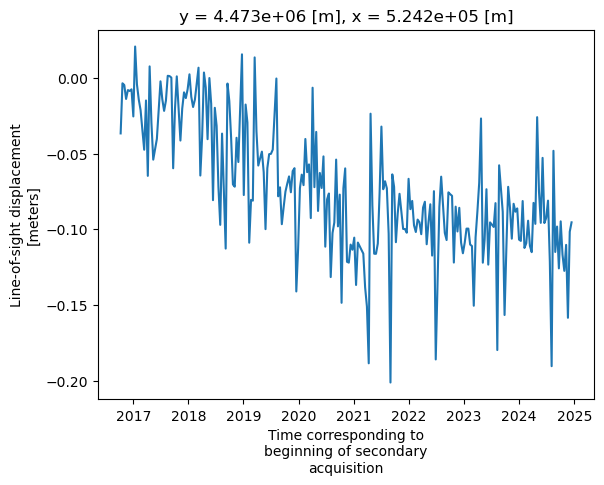

In [114]:
stack.displacement.isel(x=x, y=y).plot()

In [7]:
from dask.distributed import Client
client = Client(n_workers=10)
client.dashboard_link

'http://127.0.0.1:8787/status'

In [59]:
client.dashboard_link

'http://127.0.0.1:37526/status'

In [11]:
small_stack = stack[['displacement', 
                        'water_mask',
                        'recommended_mask',
                        'connected_component_labels']]

In [12]:
disp_df.start_date.unique()

<DatetimeArray>
['2016-07-16 22:50:42', '2016-09-26 22:50:46', '2017-10-03 22:50:51',
 '2018-04-25 22:50:50', '2018-10-22 22:50:58', '2019-05-14 22:50:57',
 '2019-11-10 22:51:05', '2020-05-08 22:51:03', '2020-11-04 22:51:11',
 '2021-05-27 22:51:10', '2021-12-05 22:51:16', '2022-06-03 22:51:17',
 '2022-12-12 22:51:21', '2023-06-10 22:51:22', '2023-12-19 22:51:25',
 '2024-06-16 22:51:24']
Length: 16, dtype: datetime64[ns]

In [14]:
stack.reference_time

KeyboardInterrupt: 

In [15]:
small_stack = stack[['displacement', 
                        'water_mask',
                        'recommended_mask',
                        'connected_component_labels']]

In [19]:
num_threads = 10
chunk_mb = stack.displacement[get_chunks_indices(stack)[0]].nbytes / (1024 ** 2)
logger.info(f'Chunk size: {chunk_mb} MB')
logger.info(f'Size of parallel run: {chunk_mb * num_threads} MB')

[INFO|3218616868|L3] 2025-02-24T09:59:01-0800: Chunk size: 238.0 MB
[INFO|3218616868|L4] 2025-02-24T09:59:01-0800: Size of parallel run: 2380.0 MB


In [22]:
small_stack

<xarray.Dataset> Size: 291GB
Dimensions:                     (time: 238, y: 7959, x: 9587)
Coordinates:
  * y                           (y) float64 64kB 4.637e+06 ... 4.399e+06
  * x                           (x) float64 77kB 4.641e+05 ... 7.516e+05
  * time                        (time) datetime64[ns] 2kB 2016-10-08T22:50:46...
Data variables:
    displacement                (time, y, x) float32 73GB dask.array<chunksize=(238, 512, 512), meta=np.ndarray>
    water_mask                  (time, y, x) float32 73GB dask.array<chunksize=(238, 512, 512), meta=np.ndarray>
    recommended_mask            (time, y, x) float32 73GB dask.array<chunksize=(238, 512, 512), meta=np.ndarray>
    connected_component_labels  (time, y, x) float32 73GB dask.array<chunksize=(238, 512, 512), meta=np.ndarray>
Attributes:
    Conventions:         CF-1.8
    contact:             opera-sds-ops@jpl.nasa.gov
    institution:         NASA JPL
    mission_name:        OPERA
    reference_document:  JPL D-108765
    title:               OPERA_L3_DISP-S1 Product

In [21]:
num_threads = 10
chunk_mb = small_stack.displacement[get_chunks_indices(stack)[0]].nbytes / (1024 ** 2)
print(f'Chunk size: {chunk_mb} MB')
print(f'Size of parallel run: {chunk_mb * num_threads} MB')

Chunk size: 238.0 MB
Size of parallel run: 2380.0 MB


In [ ]:
chunks_ix = get_chunks_indices(small_stack)
print(f'number of chunks: {len(chunks_ix)}')
small_stack['displacement'].attrs['units'] = 'm'

number of chunks: 304


In [25]:
metadata = get_metadata(disp_df.path.iloc[0], 
                    disp_df.start_date.min().strftime('%Y%m%d'))

In [26]:
# Get metadata for MintPy layout
date_list = list(small_stack['time'].dt.strftime('%Y%m%d').data)
date_list = [metadata['REF_DATE']] + date_list
dates = np.array(date_list, dtype=np.bytes_)
num_date = len(date_list)
rows, cols = small_stack.displacement.shape[1:] 

In [27]:
#pbase
pbase = np.zeros(num_date, dtype=np.float32)

# define dataset structure
dates = np.array(date_list, dtype=np.bytes_)

ds_name_dict = {
    "date": [dates.dtype, (num_date,), dates],
    "bperp": [np.float32, (num_date,), pbase],
    "timeseries": [np.float32, (num_date, rows, cols), None],
    "connectComponent" : [np.int16, (num_date, rows, cols)],
}

In [28]:
# initiate HDF5 file
output = '/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/timeseries.h5'
writefile.layout_hdf5(output, ds_name_dict, metadata=metadata)

--------------------------------------------------
create HDF5 file: /u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/timeseries.h5 with w mode
create dataset  : date             of |S8                       in size of (239,)               with compression = None
create dataset  : bperp            of <class 'numpy.float32'>   in size of (239,)               with compression = None
create dataset  : timeseries       of <class 'numpy.float32'>   in size of (239, 7959, 9587)    with compression = None
create dataset  : connectComponent of <class 'numpy.int16'>     in size of (239, 7959, 9587)    with compression = lzf
close  HDF5 file: /u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/timeseries.h5


'/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/timeseries.h5'

In [29]:
i = chunks_ix[0]

In [37]:
from tqdm import tqdm

In [61]:
client.close()

In [ ]:
client = Client(n_workers=num_threads)
client.dashboard_link

/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45270 instead
  warnings.warn(


'http://127.0.0.1:45270/status'

2025-02-24 11:09:26,051 - distributed.dashboard.components.scheduler - ERROR - 'str' object has no attribute 'text' and no __dict__ for setting new attributes
Traceback (most recent call last):
  File "/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/distributed/utils.py", line 811, in wrapper
    return func(*args, **kwargs)
  File "/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/distributed/dashboard/components/scheduler.py", line 439, in update
    self.root.title.text = title
    ^^^^^^^^^^^^^^^^^^^^
AttributeError: 'str' object has no attribute 'text' and no __dict__ for setting new attributes
2025-02-24 11:09:26,053 - distributed.dashboard.components.scheduler - ERROR - 'str' object has no attribute 'text' and no __dict__ for setting new attributes
Traceback (most recent call last):
  File "/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/distributed/utils.py", line 811, in wrapper

In [40]:
for i in tqdm(chunks_ix, total=len(chunks_ix)):
    subset = small_stack.isel(time=i[0], y=i[1], x=i[2]).compute()
    print(i)
    data = subset.displacement.values
    print(data.shape)   

    # Change slice to skip writing to the first data
    write_ix = (slice(1, None, None), i[1], i[2])
    mask = subset.recommended_mask.values == 0
    data = np.nan_to_num(data)

    f["timeseries"][write_ix] = data

    # Add connected component labels to the "connectComponent" dataset
    f["connectComponent"][write_ix] = subset.connected_component_labels.values

  0%|          | 0/304 [00:00<?, ?it/s]

(slice(None, None, None), slice(0, 512, None), slice(0, 512, None))
(238, 512, 512)


  0%|          | 1/304 [00:08<40:52,  8.09s/it]

(slice(None, None, None), slice(0, 512, None), slice(512, 1024, None))
(238, 512, 512)


  1%|          | 2/304 [00:16<41:08,  8.17s/it]

(slice(None, None, None), slice(0, 512, None), slice(1024, 1536, None))
(238, 512, 512)


  1%|          | 3/304 [00:25<43:27,  8.66s/it]

(slice(None, None, None), slice(0, 512, None), slice(1536, 2048, None))
(238, 512, 512)


  1%|▏         | 4/304 [00:32<40:38,  8.13s/it]

(slice(None, None, None), slice(0, 512, None), slice(2048, 2560, None))
(238, 512, 512)


  2%|▏         | 5/304 [00:40<39:30,  7.93s/it]

(slice(None, None, None), slice(0, 512, None), slice(2560, 3072, None))
(238, 512, 512)


  2%|▏         | 6/304 [00:49<40:54,  8.24s/it]

(slice(None, None, None), slice(0, 512, None), slice(3072, 3584, None))
(238, 512, 512)


  2%|▏         | 7/304 [00:56<39:06,  7.90s/it]

(slice(None, None, None), slice(0, 512, None), slice(3584, 4096, None))
(238, 512, 512)


  3%|▎         | 8/304 [01:04<39:17,  7.96s/it]

(slice(None, None, None), slice(0, 512, None), slice(4096, 4608, None))
(238, 512, 512)


  3%|▎         | 9/304 [01:11<37:42,  7.67s/it]

(slice(None, None, None), slice(0, 512, None), slice(4608, 5120, None))
(238, 512, 512)


  3%|▎         | 10/304 [01:26<42:11,  8.61s/it]


KeyboardInterrupt: 

Process Dask Worker process (from Nanny):
2025-02-24 10:19:04,860 - distributed.nanny - ERROR - Worker process died unexpectedly
2025-02-24 10:19:04,861 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
Traceback (most recent call last):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
  File "/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/asyncio/base_events.py", line 725, in run_until_complete
    return future.result()
           ~~~~~~~~~~~~~^^
  File "/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/distributed/nanny.py", line 985, in run
    await worker.finished()
  File "/u/trappist-r0/govorcin/src

In [30]:
subset = small_stack.isel(time=i[0], y=i[1], x=i[2]).compute()
data = subset.displacement.values
print(data.shape)

(238, 512, 512)


In [31]:
 # Change slice to skip writing to the first data
write_ix = (slice(1, None, None), i[1], i[2])

mask = subset.recommended_mask.values == 0


In [32]:
mask.shape

(238, 512, 512)

In [33]:
data

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [34]:
f = h5py.File(output, "a")

In [36]:
f["timeseries"][write_ix] = data
f["connectComponent"][write_ix] = subset.connected_component_labels.values

In [10]:
metadata = get_metadata(disp_df.path.iloc[0], 
                    disp_df.start_date.min().strftime('%Y%m%d'))

In [12]:
# Get metadata for MintPy layout
date_list = list(stack['time'].dt.strftime('%Y%m%d').data)
date_list = [metadata['REF_DATE']] + date_list
dates = np.array(date_list, dtype=np.bytes_)
num_date = len(date_list)
rows, cols = stack.displacement.shape[1:] 

In [15]:
#pbase
pbase = np.zeros(num_date, dtype=np.float32)

# define dataset structure
dates = np.array(date_list, dtype=np.bytes_)

ds_name_dict = {
    "date": [dates.dtype, (num_date,), dates],
    "bperp": [np.float32, (num_date,), pbase],
    "timeseries": [np.float32, (num_date, rows, cols), None],
    "connectComponent" : [np.int16, (num_date, rows, cols)],
}

In [16]:
output = '/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/timeseries.h5'

In [17]:
writefile.layout_hdf5(output, ds_name_dict, metadata=metadata)

--------------------------------------------------
create HDF5 file: /u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/timeseries.h5 with w mode
create dataset  : date             of |S8                       in size of (239,)               with compression = None
create dataset  : bperp            of <class 'numpy.float32'>   in size of (239,)               with compression = None
create dataset  : timeseries       of <class 'numpy.float32'>   in size of (239, 7959, 9587)    with compression = None
create dataset  : connectComponent of <class 'numpy.int16'>     in size of (239, 7959, 9587)    with compression = lzf
close  HDF5 file: /u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/timeseries.h5


'/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/timeseries.h5'

In [25]:
from dask.distributed import Client
client = Client(n_workers=10, threads_per_worker=1, memory_limit='4GB')
client.dashboard_link

'http://127.0.0.1:8787/status'

In [22]:
stack = stack.chunk({'time':-1})

In [26]:
%%time
i = chunks_ix[0]
data = stack.displacement[i].values

# Change slice to skip writing to the first data
write_ix = (slice(1, None, None), i[1], i[2])

CPU times: user 985 ms, sys: 567 ms, total: 1.55 s
Wall time: 2.5 s


In [42]:
data.shape

(238, 512, 512)

In [83]:
stack.displacement.isel(y=y,x=x).plot()

NameError: name 'stack' is not defined

In [53]:
%%time
small_stack = stack[['displacement', 'water_mask', 'connected_component_labels']]

CPU times: user 95 μs, sys: 33 μs, total: 128 μs
Wall time: 143 μs


In [56]:
%%time
data = small_stack.isel(time=i[0], y=i[1], x=i[2]).compute()

CPU times: user 1.98 s, sys: 1.61 s, total: 3.58 s
Wall time: 4.61 s


In [68]:
list(small_stack.keys())

['displacement', 'water_mask', 'connected_component_labels']

In [76]:
import numpy 
import random
def find_reference_point(pct_mask, pct_ps, phase_jumps=None, percentile=99, max_jumps=1):

    """
    Selects a reference point where the ps percenatge is above the 99 percentile
    and percentage mask is nonzero. If sum of phase jumps is specified, use it 
    for futher refining to exclude ps pixels with jumps 

    Parameters:
        pct_mask (np.ndarray): Percentage mask (nonzero values indicate valid regions).
        pct_ps (np.ndarray):  Percentage of ps stability in the stack (100% stays ps).
        phase_jumps (np.ndarray):  NUmber of 2pi phase jumps in the stack.

    Returns:
        (int, int): y, x coordinates of the selected reference point.
    """
    # Get valid pixes by masking out 100% recommended mask and 0% of pixels in the stack 
    valid_pixels =  np.ma.masked_where((pct_ps == 0) | (pct_mask == 100),
                                        pct_ps)
    
    # Compute 90th percentile threshold over valid pixels
    threshold = np.nanpercentile(valid_pixels.filled(np.nan), percentile)
    
    # Create a mask for high-coherence pixels
    valid = (valid_pixels >= threshold) 

    # if timeseries inversion residualt metric is specified 
    # remove pixels with > 1 phase jumps
    if phase_jumps:
        valid[np.where((valid == 1) & (phase_jumps > max_jumps))] = 0
    
    # Get indices of valid pixels
    valid_indices = np.argwhere(valid.filled(0))
    
    if valid_indices.size == 0:
        raise ValueError("No valid reference point found. Adjust threshold or check input data.")

    # Randomly select one valid pixel
    y, x = np.squeeze(random.choice(valid_indices))
    
    # Flip y-axis if needed (assuming `y` is inverted)
    #y = mean_tcoh.shape[0] - 1 - y

    print(f'Selected reference pixel (y/x): {(y, x)}')
    
    return y, x

In [50]:
mask_pct = io.open_image('/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/quality_metrics/pct_recommended_mask.tif')
ps_pct = io.open_image('/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/quality_metrics/pct_persistent_scatterer_mask.tif')
inv_res = io.open_image('/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/quality_metrics/timeseries_inversion_residuals_sum.tif') 

In [69]:
pct_ps=ps_pct[0]
pct_mask=mask_pct[0]
phase_jumps=None
max_jumps=1
percentile=99


In [70]:
# Get valid pixes by masking out 100% recommended mask and 0% of pixels in the stack 
valid_pixels =  np.ma.masked_where((pct_ps == 0) | (pct_mask == 100),
                                    pct_ps)

# Compute 90th percentile threshold over valid pixels
threshold = np.nanpercentile(valid_pixels.filled(np.nan), percentile)

# Create a mask for high-coherence pixels
valid = (valid_pixels >= threshold) 

# if timeseries inversion residualt metric is specified 
# remove pixels with > 1 phase jumps
if phase_jumps:
    valid[np.where((valid == 1) & (phase_jumps > max_jumps))] = 0

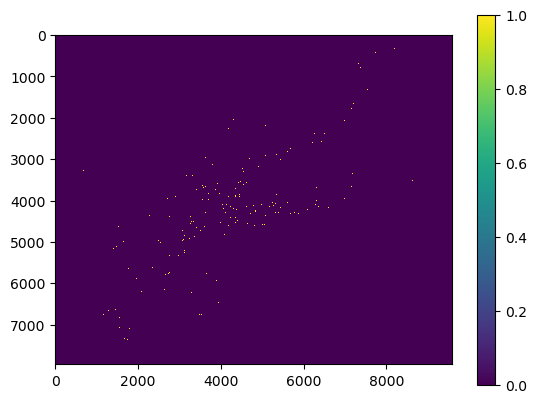

In [78]:
valid_indices = np.argwhere(valid.filled(0))
plt.imshow(valid.filled(0), interpolation='nearest')
plt.colorbar()

In [79]:
y, x = find_reference_point(mask_pct[0], ps_pct[0])

Selected reference pixel (y/x): (np.int64(5492), np.int64(2004))


In [82]:
pct_ps[y,x]

np.float32(100.0)

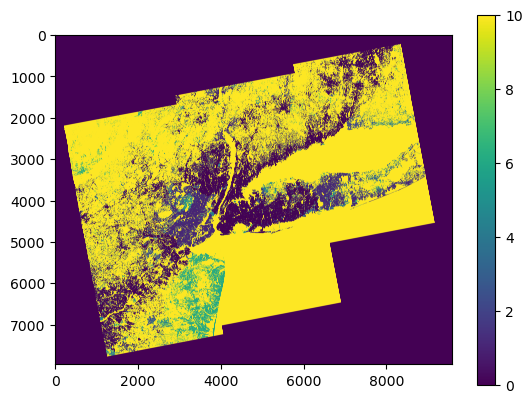

In [37]:
plt.imshow(np.round(inv_res[0],0), clim=[0,10])
plt.colorbar()

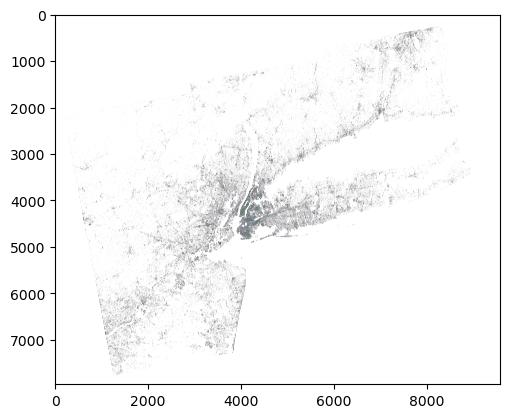

In [46]:
plt.imshow(np.ma.masked_where((ps_pct[0] == 0) | (mask_pct[0] == 100), ps_pct[0]))

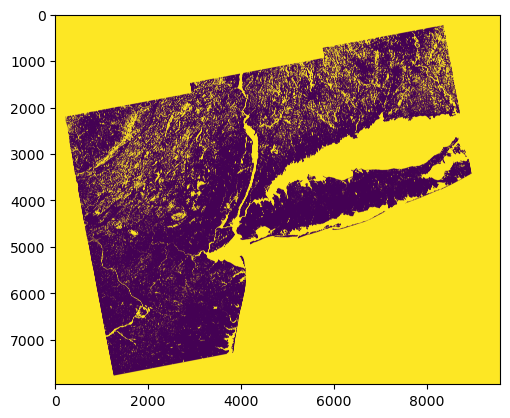

In [40]:
plt.imshow(mask_pct[0]==100)

In [24]:
threshold = np.nanpercentile(np.ma.masked_equal(ps_pct[0],0).filled(np.nan), 95)
threshold

np.float32(94.53782)

In [25]:
threshold = np.nanpercentile(np.ma.masked_equal(mask_pct[0],0).filled(np.nan), 95)
threshold

np.float32(100.0)

In [26]:
high_coherence_mask = (ps_pct[0] >= threshold) 

In [33]:
high_coherence_mask[np.where((high_coherence_mask == 1) & (inv_res[0]>1))] = 0

In [ ]:
mask2 = ()

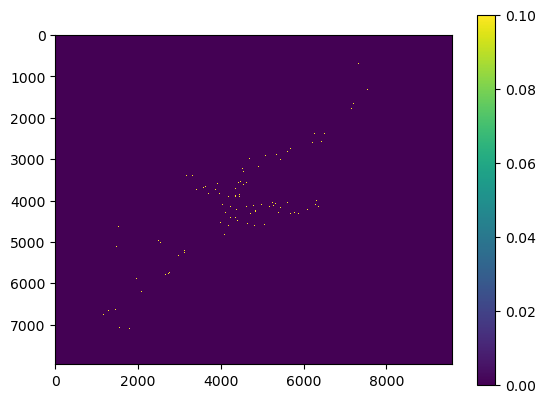

In [34]:
plt.imshow(high_coherence_mask, clim=[0,0.1], interpolation='nearest')
plt.colorbar()

In [27]:
%%time
mask = stack.water_mask[i].values == 0 

CPU times: user 1.35 s, sys: 666 ms, total: 2.02 s
Wall time: 4.33 s


In [28]:
data = np.ma.masked_array(data, mask=mask).filled(np.nan)

In [6]:
from matplotlib import pyplot as plt

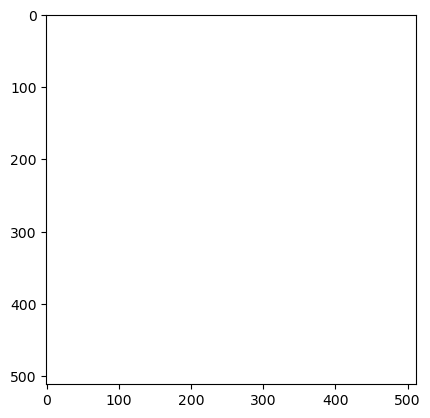

In [37]:
plt.imshow(data[-1])

In [38]:
f =  h5py.File(output, "a")

In [40]:
%%time
f["timeseries"][write_ix] = data

CPU times: user 74.5 ms, sys: 122 ms, total: 196 ms
Wall time: 180 ms


In [41]:
%%time
f["connectComponent"][write_ix] = stack.connected_component_labels[i].values

CPU times: user 1.15 s, sys: 670 ms, total: 1.82 s
Wall time: 4.13 s
